In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import random
import time
import os

from C4_adapter_only.Env.c4_env import ConnectFourEnv, BOARD_ROWS, BOARD_COLS
from C4_adapter_only.Agents.c4_random import ConnectFourRandomAgent
from C4_adapter_only.Agents.c4_mcts import ConnectFourMCTSAgent
from C4_adapter_only.Agents.c4_dqn import ConnectFourDQNAgent
from C4_adapter_only.Agents.c4_alphazero.c4_az_agent import ConnectFourAlphaZeroAgent
from C4_adapter_only.Agents.c4_alphazero.c4_model import ConnectFourAlphaZeroNet
from C4_adapter_only.Agents.c4_alphazero.c4_train import train_loop


from C4_adapter_only.Utils.c4_evaluate_agent import evaluate_connect_four_agent
from C4_adapter_only.Utils.c4_visualize_game import visualize_connect_four_game

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

os.makedirs("models", exist_ok=True)

In [19]:
# Initialize the environment
env = ConnectFourEnv()

# Initialize Random Agent
random_agent = ConnectFourRandomAgent()

# Initialize MCTS Agent with different simulation counts
mcts_agent_fast = ConnectFourMCTSAgent(num_simulations=100)
mcts_agent = ConnectFourMCTSAgent(num_simulations=200)
mcts_agent_deep = ConnectFourMCTSAgent(num_simulations=500)

# Initialize DQN Agent
dqn_agent = ConnectFourDQNAgent(
    state_shape=(BOARD_ROWS, BOARD_COLS),
    action_size=BOARD_COLS,
    memory_size=10000,
    gamma=0.95,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    learning_rate=0.001,
    batch_size=64,
    update_target_freq=10,
    reward_scale=10.0,
)

# Initialize AlphaZero Agent
alpha_zero_net = ConnectFourAlphaZeroNet()  
alpha_zero_agent = ConnectFourAlphaZeroAgent(alpha_zero_net, num_simulations=100) 
print(f"Device used for DQN: {dqn_agent.device}")

Device used for DQN: cuda


In [ ]:
#training the alpha zero agent
training_losses, training_rewards = train_loop()

Iteration 1/200, Loss: 2.9103, Final Reward: 1.00
Iteration 2/200, Loss: 2.7252, Final Reward: 1.00
Iteration 3/200, Loss: 2.3988, Final Reward: 1.00
Iteration 4/200, Loss: 3.2350, Final Reward: 1.00
Iteration 5/200, Loss: 2.8108, Final Reward: 1.00
Iteration 6/200, Loss: 2.7334, Final Reward: 1.00
Iteration 7/200, Loss: 2.0003, Final Reward: 1.00
Iteration 8/200, Loss: 2.0591, Final Reward: 1.00
Iteration 9/200, Loss: 2.6702, Final Reward: 1.00
Iteration 10/200, Loss: 2.3572, Final Reward: 1.00
Iteration 11/200, Loss: 2.9414, Final Reward: 1.00
Iteration 12/200, Loss: 3.1131, Final Reward: 1.00
Iteration 13/200, Loss: 3.1403, Final Reward: 1.00
Iteration 14/200, Loss: 2.3166, Final Reward: 1.00
Iteration 15/200, Loss: 2.3224, Final Reward: 1.00
Iteration 16/200, Loss: 2.1505, Final Reward: 1.00
Iteration 17/200, Loss: 2.2288, Final Reward: 1.00
Iteration 18/200, Loss: 2.3333, Final Reward: 1.00
Iteration 19/200, Loss: 2.1251, Final Reward: 1.00
Iteration 20/200, Loss: 2.4117, Final Re

In [3]:
alpha_zero_model_path = "models/connect_four_alphazero_trained.pt"
torch.save(alpha_zero_agent.network.state_dict(), alpha_zero_model_path)
print(f"Model saved at {alpha_zero_model_path}")


Model saved at models/connect_four_alphazero_trained.pt


In [4]:
# Initialize AlphaZero Agent
alpha_zero_net = ConnectFourAlphaZeroNet()  
alpha_zero_agent = ConnectFourAlphaZeroAgent(alpha_zero_net, num_simulations=100)

# Load pre-trained AlphaZero model
alpha_zero_model_path = "/home/euler03/projects/rl_gym/src/C4_adapter_only/Models/connect_four_alphazero_trained.pt"
if os.path.exists(alpha_zero_model_path):
    print("Loading pre-trained AlphaZero model...")
    alpha_zero_agent.network.load_state_dict(torch.load(alpha_zero_model_path))
    alpha_zero_agent.network.eval()
else:
    print("Warning: Pre-trained AlphaZero model not found!")


Loading pre-trained AlphaZero model...


In [21]:
# Define opponents and their probabilities
opponents = {
    'self': dqn_agent,  # Self-play
    'random': random_agent,
    'mcts_fast': mcts_agent_fast,
    'alpha_zero': alpha_zero_agent
}

# Define opponent probabilities 
opponent_probs = {
    'self': 0.75,
    'random': 0.10,
    'alpha_zero': 0.15,
    'mcts_fast': 0.20
}

# Number of training episodes
num_episodes = 1000

# Train the DQN agent
print(f"Training DQN agent for {num_episodes} episodes...")
rewards, losses = dqn_agent.train(env, num_episodes=num_episodes, 
                                 opponents=opponents, opponent_probs=opponent_probs)

# Save the trained model
dqn_agent.save("C4_adapter_only/Models/connect_four_dqn_trained1")
print("DQN agent training completed and model saved.")

Training DQN agent for 1000 episodes...
Episode 10/1000
   Opponent: self
   Total Reward: 10.00
   Avg Loss: 0.2811
   Epsilon: 0.7705
Episode 20/1000
   Opponent: mcts_fast
   Total Reward: 10.00
   Avg Loss: 0.1992
   Epsilon: 0.5058
Episode 30/1000
   Opponent: random
   Total Reward: 10.00
   Avg Loss: 0.5422
   Epsilon: 0.2689
Episode 40/1000
   Opponent: alpha_zero
   Total Reward: 0.00
   Avg Loss: 0.8025
   Epsilon: 0.1589
Episode 50/1000
   Opponent: self
   Total Reward: 10.00
   Avg Loss: 1.7932
   Epsilon: 0.0911
Episode 60/1000
   Opponent: mcts_fast
   Total Reward: 0.00
   Avg Loss: 1.0669
   Epsilon: 0.0541
Episode 70/1000
   Opponent: self
   Total Reward: 10.00
   Avg Loss: 1.2849
   Epsilon: 0.0304
Episode 80/1000
   Opponent: self
   Total Reward: 10.00
   Avg Loss: 1.8915
   Epsilon: 0.0175
Episode 90/1000
   Opponent: self
   Total Reward: 0.00
   Avg Loss: 3.9332
   Epsilon: 0.0100
Episode 100/1000
   Opponent: mcts_fast
   Total Reward: 10.00
   Avg Loss: 6.766

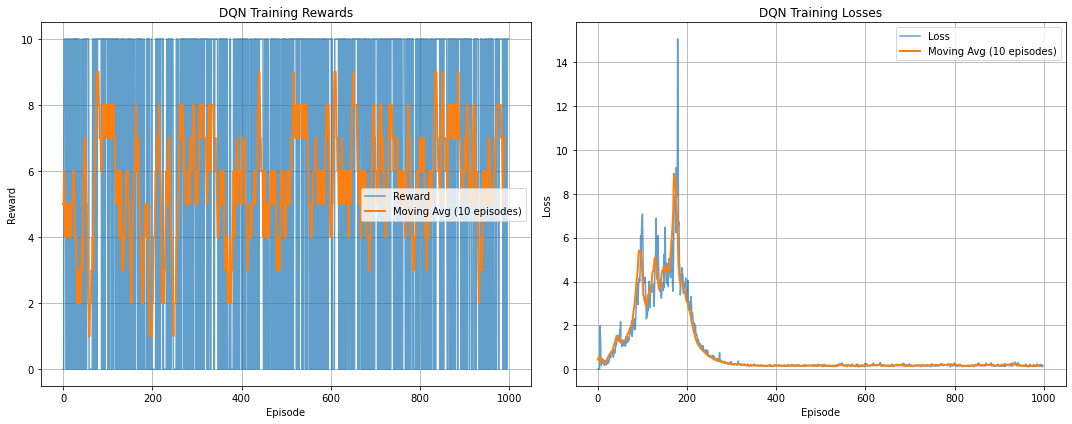

In [ ]:
# Plot rewards and losses
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(rewards, label='Reward', alpha=0.7)
plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), label='Moving Avg (10 episodes)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Training Rewards')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(losses, label='Loss', alpha=0.7)
plt.plot(np.convolve(losses, np.ones(10)/10, mode='valid'), label='Moving Avg (10 episodes)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('DQN Training Losses')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:
# Number of evaluation games
num_eval_games = 50

print("Evaluating agents...")

# Evaluate DQN vs Random
dqn_vs_random = evaluate_connect_four_agent(dqn_agent, random_agent, num_games=num_eval_games)
random_vs_dqn = evaluate_connect_four_agent(random_agent, dqn_agent, num_games=num_eval_games)

# Evaluate DQN vs MCTS
dqn_vs_mcts = evaluate_connect_four_agent(dqn_agent, mcts_agent, num_games=num_eval_games)
mcts_vs_dqn = evaluate_connect_four_agent(mcts_agent, dqn_agent, num_games=num_eval_games)

# Evaluate MCTS vs Random
mcts_vs_random = evaluate_connect_four_agent(mcts_agent, random_agent, num_games=num_eval_games)
random_vs_mcts = evaluate_connect_four_agent(random_agent, mcts_agent, num_games=num_eval_games)

# Evaluate AlphaZero vs other agents
az_vs_random = evaluate_connect_four_agent(alpha_zero_agent, random_agent, num_games=num_eval_games)
random_vs_az = evaluate_connect_four_agent(random_agent, alpha_zero_agent, num_games=num_eval_games)

az_vs_mcts = evaluate_connect_four_agent(alpha_zero_agent, mcts_agent, num_games=num_eval_games)
mcts_vs_az = evaluate_connect_four_agent(mcts_agent, alpha_zero_agent, num_games=num_eval_games)

az_vs_dqn = evaluate_connect_four_agent(alpha_zero_agent, dqn_agent, num_games=num_eval_games)
dqn_vs_az = evaluate_connect_four_agent(dqn_agent, alpha_zero_agent, num_games=num_eval_games)

# Evaluate DQN vs DQN and MCTS vs MCTS
dqn_vs_dqn = evaluate_connect_four_agent(dqn_agent, dqn_agent, num_games=num_eval_games)
mcts_vs_mcts = evaluate_connect_four_agent(mcts_agent, mcts_agent, num_games=num_eval_games)

# Evaluate AlphaZero vs AlphaZero
az_vs_az = evaluate_connect_four_agent(alpha_zero_agent, alpha_zero_agent, num_games=num_eval_games)

# Evaluate Random vs Random
random_vs_random = evaluate_connect_four_agent(random_agent, random_agent, num_games=num_eval_games*200)

# Print evaluation results
print("\nEvaluation Results:")
print(f"DQN (RED) vs Random (YELLOW): Win Rate {dqn_vs_random['win_rate']:.2%}, Avg Reward {dqn_vs_random['avg_reward']:.2f}")
print(f"Random (RED) vs DQN (YELLOW): Win Rate {random_vs_dqn['win_rate']:.2%}, Avg Reward {random_vs_dqn['avg_reward']:.2f}")

print(f"DQN (RED) vs MCTS (YELLOW): Win Rate {dqn_vs_mcts['win_rate']:.2%}, Avg Reward {dqn_vs_mcts['avg_reward']:.2f}")
print(f"MCTS (RED) vs DQN (YELLOW): Win Rate {mcts_vs_dqn['win_rate']:.2%}, Avg Reward {mcts_vs_dqn['avg_reward']:.2f}")

print(f"MCTS (RED) vs Random (YELLOW): Win Rate {mcts_vs_random['win_rate']:.2%}, Avg Reward {mcts_vs_random['avg_reward']:.2f}")
print(f"Random (RED) vs MCTS (YELLOW): Win Rate {random_vs_mcts['win_rate']:.2%}, Avg Reward {random_vs_mcts['avg_reward']:.2f}")

print(f"AlphaZero (RED) vs Random (YELLOW): Win Rate {az_vs_random['win_rate']:.2%}, Avg Reward {az_vs_random['avg_reward']:.2f}")
print(f"Random (RED) vs AlphaZero (YELLOW): Win Rate {random_vs_az['win_rate']:.2%}, Avg Reward {random_vs_az['avg_reward']:.2f}")

print(f"AlphaZero (RED) vs MCTS (YELLOW): Win Rate {az_vs_mcts['win_rate']:.2%}, Avg Reward {az_vs_mcts['avg_reward']:.2f}")
print(f"MCTS (RED) vs AlphaZero (YELLOW): Win Rate {mcts_vs_az['win_rate']:.2%}, Avg Reward {mcts_vs_az['avg_reward']:.2f}")

print(f"AlphaZero (RED) vs DQN (YELLOW): Win Rate {az_vs_dqn['win_rate']:.2%}, Avg Reward {az_vs_dqn['avg_reward']:.2f}")
print(f"DQN (RED) vs AlphaZero (YELLOW): Win Rate {dqn_vs_az['win_rate']:.2%}, Avg Reward {dqn_vs_az['avg_reward']:.2f}")

print(f"DQN (RED) vs DQN (YELLOW): Win Rate {dqn_vs_dqn['win_rate']:.2%}, Avg Reward {dqn_vs_dqn['avg_reward']:.2f}")
print(f"MCTS (RED) vs MCTS (YELLOW): Win Rate {mcts_vs_mcts['win_rate']:.2%}, Avg Reward {mcts_vs_mcts['avg_reward']:.2f}")

print(f"AlphaZero (RED) vs AlphaZero (YELLOW): Win Rate {az_vs_az['win_rate']:.2%}, Avg Reward {az_vs_az['avg_reward']:.2f}")

print(f"Random (RED) vs Random (YELLOW): Win Rate {random_vs_random['win_rate']:.2%}, Avg Reward {random_vs_random['avg_reward']:.2f}")


Evaluating agents...


Connect4_Random vs Connect4_Random: 100%|██████████| 10000/10000 [00:13<00:00, 748.24it/s]


Evaluation Results:
DQN (RED) vs Random (YELLOW): Win Rate 90.00%, Avg Reward 0.90
Random (RED) vs DQN (YELLOW): Win Rate 66.00%, Avg Reward 0.66
DQN (RED) vs MCTS (YELLOW): Win Rate 98.00%, Avg Reward 0.98
MCTS (RED) vs DQN (YELLOW): Win Rate 74.00%, Avg Reward 0.74
MCTS (RED) vs Random (YELLOW): Win Rate 48.00%, Avg Reward 0.48
Random (RED) vs MCTS (YELLOW): Win Rate 54.00%, Avg Reward 0.54
AlphaZero (RED) vs Random (YELLOW): Win Rate 62.00%, Avg Reward 0.62
Random (RED) vs AlphaZero (YELLOW): Win Rate 58.00%, Avg Reward 0.58
AlphaZero (RED) vs MCTS (YELLOW): Win Rate 62.00%, Avg Reward 0.62
MCTS (RED) vs AlphaZero (YELLOW): Win Rate 68.00%, Avg Reward 0.68
AlphaZero (RED) vs DQN (YELLOW): Win Rate 66.00%, Avg Reward 0.66
DQN (RED) vs AlphaZero (YELLOW): Win Rate 100.00%, Avg Reward 1.00
DQN (RED) vs DQN (YELLOW): Win Rate 96.00%, Avg Reward 0.96
MCTS (RED) vs MCTS (YELLOW): Win Rate 64.00%, Avg Reward 0.64
AlphaZero (RED) vs AlphaZero (YELLOW): Win Rate 68.00%, Avg Reward 0.68
Rand

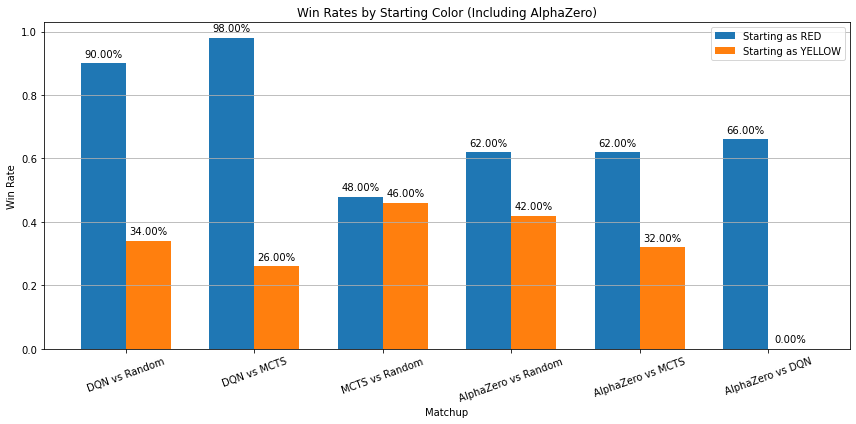


Starting Color Advantage Analysis:
DQN vs Random: RED advantage = 56.00%
DQN vs MCTS: RED advantage = 72.00%
MCTS vs Random: RED advantage = 2.00%
AlphaZero vs Random: RED advantage = 20.00%
AlphaZero vs MCTS: RED advantage = 30.00%
AlphaZero vs DQN: RED advantage = 66.00%


In [ ]:
# Dictionaries to store results by starting color
red_results = {
    'DQN vs Random': dqn_vs_random,
    'DQN vs MCTS': dqn_vs_mcts,
    'MCTS vs Random': mcts_vs_random,
    'AlphaZero vs Random': az_vs_random,
    'AlphaZero vs MCTS': az_vs_mcts,
    'AlphaZero vs DQN': az_vs_dqn
}

yellow_results = {
    'Random vs DQN': random_vs_dqn,
    'MCTS vs DQN': mcts_vs_dqn,
    'Random vs MCTS': random_vs_mcts,
    'Random vs AlphaZero': random_vs_az,
    'MCTS vs AlphaZero': mcts_vs_az,
    'DQN vs AlphaZero': dqn_vs_az
}


# Matchup pairs for analysis
matchup_pairs = [
    ('DQN vs Random', 'Random vs DQN'),
    ('DQN vs MCTS', 'MCTS vs DQN'),
    ('MCTS vs Random', 'Random vs MCTS'),
    ('AlphaZero vs Random', 'Random vs AlphaZero'),
    ('AlphaZero vs MCTS', 'MCTS vs AlphaZero'),
    ('AlphaZero vs DQN', 'DQN vs AlphaZero')
]


# Plot win rates by starting color
plt.figure(figsize=(12, 6))

matchups = [pair[0] for pair in matchup_pairs]
red_win_rates = [red_results[pair[0]]['win_rate'] for pair in matchup_pairs]
yellow_win_rates = [1 - yellow_results[pair[1]]['win_rate'] for pair in matchup_pairs]  # Invert for same perspective

x = np.arange(len(matchups))
width = 0.35

plt.bar(x - width/2, red_win_rates, width, label='Starting as RED')
plt.bar(x + width/2, yellow_win_rates, width, label='Starting as YELLOW')

plt.xlabel('Matchup')
plt.ylabel('Win Rate')
plt.title('Win Rates by Starting Color (Including AlphaZero)')
plt.xticks(x, matchups, rotation=20)
plt.legend()
plt.grid(True, axis='y')

for i, v in enumerate(red_win_rates):
    plt.text(i - width/2, v + 0.02, f'{v:.2%}', ha='center')
for i, v in enumerate(yellow_win_rates):
    plt.text(i + width/2, v + 0.02, f'{v:.2%}', ha='center')

plt.tight_layout()
plt.show()

print("\nStarting Color Advantage Analysis:")
for (red_matchup, yellow_matchup) in matchup_pairs:
    red_win = red_results[red_matchup]['win_rate']
    yellow_win = 1 - yellow_results[yellow_matchup]['win_rate']  # Invert to get same perspective
    advantage = red_win - yellow_win
    print(f"{red_matchup}: RED advantage = {advantage:.2%}")


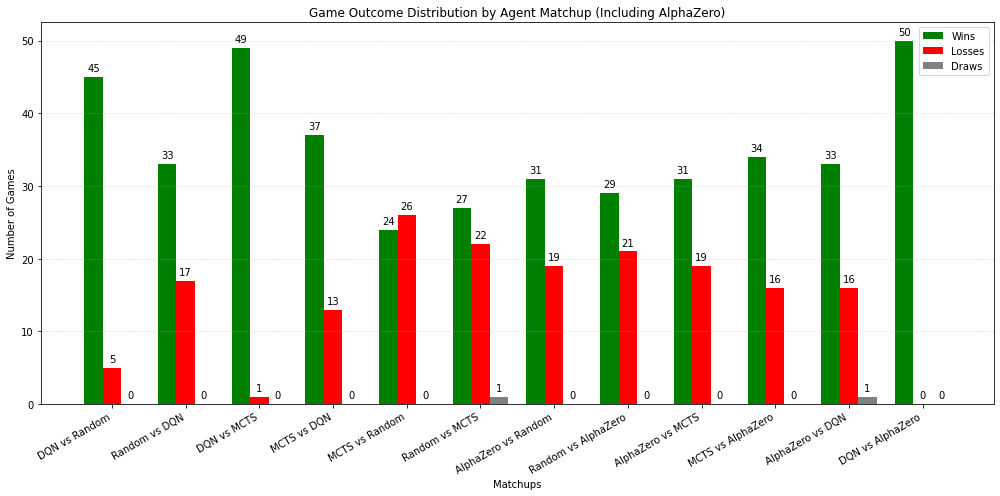

In [ ]:
# Create a structured dataset from evaluation results
results = {
    "Agent": [
        "DQN vs Random", "Random vs DQN", 
        "DQN vs MCTS", "MCTS vs DQN",
        "MCTS vs Random", "Random vs MCTS",
        "AlphaZero vs Random", "Random vs AlphaZero",
        "AlphaZero vs MCTS", "MCTS vs AlphaZero",
        "AlphaZero vs DQN", "DQN vs AlphaZero"
    ],
    "Wins": [
        dqn_vs_random['wins'], random_vs_dqn['wins'],
        dqn_vs_mcts['wins'], mcts_vs_dqn['wins'],
        mcts_vs_random['wins'], random_vs_mcts['wins'],
        az_vs_random['wins'], random_vs_az['wins'],
        az_vs_mcts['wins'], mcts_vs_az['wins'],
        az_vs_dqn['wins'], dqn_vs_az['wins']
    ],
    "Losses": [
        dqn_vs_random['losses'], random_vs_dqn['losses'],
        dqn_vs_mcts['losses'], mcts_vs_dqn['losses'],
        mcts_vs_random['losses'], random_vs_mcts['losses'],
        az_vs_random['losses'], random_vs_az['losses'],
        az_vs_mcts['losses'], mcts_vs_az['losses'],
        az_vs_dqn['losses'], dqn_vs_az['losses']
    ],
    "Draws": [
        dqn_vs_random['draws'], random_vs_dqn['draws'],
        dqn_vs_mcts['draws'], mcts_vs_dqn['draws'],
        mcts_vs_random['draws'], random_vs_mcts['draws'],
        az_vs_random['draws'], random_vs_az['draws'],
        az_vs_mcts['draws'], mcts_vs_az['draws'],
        az_vs_dqn['draws'], dqn_vs_az['draws']
    ]
}

# Visualization of game outcome distribution (wins, losses, draws)
plt.figure(figsize=(14, 7))

agents = results["Agent"]
wins = results["Wins"]
losses = results["Losses"]
draws = results["Draws"]

x = np.arange(len(agents))  
width = 0.25  

plt.bar(x - width, wins, width, label='Wins', color='green')
plt.bar(x, losses, width, label='Losses', color='red')
plt.bar(x + width, draws, width, label='Draws', color='gray')

plt.xlabel('Matchups')
plt.ylabel('Number of Games')
plt.title('Game Outcome Distribution by Agent Matchup (Including AlphaZero)')
plt.xticks(x, agents, rotation=30, ha='right')
plt.legend()

for i, v in enumerate(wins):
    plt.text(i - width, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(losses):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(draws):
    plt.text(i + width, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()



Measuring agent decision times...


Measuring Connect4_Random performance: 100%|██████████| 100/100 [00:00<00:00, 3442.92it/s]


DEBUG: Connect4_Random chose action = 3, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 3, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 0, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 2, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 4, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 4, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 4, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 0, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 1, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 2, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 4, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 5, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 6, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 4, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 6, Type = <class 'int'>
DEBUG: Connect4_Random chose action = 6, Type = <class 'int'>
DEBUG: C

Measuring Connect4_MCTS_100 performance:   2%|▏         | 1/50 [00:00<00:07,  6.67it/s]

DEBUG: Connect4_MCTS_100 chose action = 2, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:   4%|▍         | 2/50 [00:00<00:07,  6.77it/s]

DEBUG: Connect4_MCTS_100 chose action = 1, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:   6%|▌         | 3/50 [00:00<00:06,  6.98it/s]

DEBUG: Connect4_MCTS_100 chose action = 6, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:   8%|▊         | 4/50 [00:00<00:06,  6.88it/s]

DEBUG: Connect4_MCTS_100 chose action = 6, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  10%|█         | 5/50 [00:00<00:06,  7.02it/s]

DEBUG: Connect4_MCTS_100 chose action = 0, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  12%|█▏        | 6/50 [00:00<00:06,  6.32it/s]

DEBUG: Connect4_MCTS_100 chose action = 1, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  14%|█▍        | 7/50 [00:01<00:06,  6.46it/s]

DEBUG: Connect4_MCTS_100 chose action = 6, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  16%|█▌        | 8/50 [00:01<00:06,  6.81it/s]

DEBUG: Connect4_MCTS_100 chose action = 4, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  18%|█▊        | 9/50 [00:01<00:05,  7.16it/s]

DEBUG: Connect4_MCTS_100 chose action = 3, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  20%|██        | 10/50 [00:01<00:05,  7.42it/s]

DEBUG: Connect4_MCTS_100 chose action = 6, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  22%|██▏       | 11/50 [00:01<00:05,  7.08it/s]

DEBUG: Connect4_MCTS_100 chose action = 3, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  24%|██▍       | 12/50 [00:01<00:05,  6.95it/s]

DEBUG: Connect4_MCTS_100 chose action = 0, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  26%|██▌       | 13/50 [00:01<00:05,  6.90it/s]

DEBUG: Connect4_MCTS_100 chose action = 3, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  28%|██▊       | 14/50 [00:02<00:05,  7.10it/s]

DEBUG: Connect4_MCTS_100 chose action = 3, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  30%|███       | 15/50 [00:02<00:04,  7.33it/s]

DEBUG: Connect4_MCTS_100 chose action = 4, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  32%|███▏      | 16/50 [00:02<00:04,  7.72it/s]

DEBUG: Connect4_MCTS_100 chose action = 0, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  34%|███▍      | 17/50 [00:02<00:04,  8.03it/s]

DEBUG: Connect4_MCTS_100 chose action = 5, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  38%|███▊      | 19/50 [00:02<00:03,  9.33it/s]

DEBUG: Connect4_MCTS_100 chose action = 3, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 6, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  42%|████▏     | 21/50 [00:02<00:03,  8.17it/s]

DEBUG: Connect4_MCTS_100 chose action = 6, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 3, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  46%|████▌     | 23/50 [00:03<00:03,  7.88it/s]

DEBUG: Connect4_MCTS_100 chose action = 6, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 4, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  50%|█████     | 25/50 [00:03<00:03,  7.92it/s]

DEBUG: Connect4_MCTS_100 chose action = 1, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 5, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  54%|█████▍    | 27/50 [00:03<00:02,  8.31it/s]

DEBUG: Connect4_MCTS_100 chose action = 1, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 2, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  58%|█████▊    | 29/50 [00:03<00:02,  7.56it/s]

DEBUG: Connect4_MCTS_100 chose action = 2, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 5, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  62%|██████▏   | 31/50 [00:04<00:02,  7.30it/s]

DEBUG: Connect4_MCTS_100 chose action = 3, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 2, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  66%|██████▌   | 33/50 [00:04<00:02,  7.09it/s]

DEBUG: Connect4_MCTS_100 chose action = 4, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 6, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  70%|███████   | 35/50 [00:04<00:02,  7.14it/s]

DEBUG: Connect4_MCTS_100 chose action = 2, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 4, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  74%|███████▍  | 37/50 [00:04<00:01,  7.27it/s]

DEBUG: Connect4_MCTS_100 chose action = 2, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 6, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  78%|███████▊  | 39/50 [00:05<00:01,  7.65it/s]

DEBUG: Connect4_MCTS_100 chose action = 5, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 3, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  82%|████████▏ | 41/50 [00:05<00:01,  7.68it/s]

DEBUG: Connect4_MCTS_100 chose action = 4, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 1, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  86%|████████▌ | 43/50 [00:05<00:00,  7.07it/s]

DEBUG: Connect4_MCTS_100 chose action = 3, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 3, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  90%|█████████ | 45/50 [00:06<00:00,  6.96it/s]

DEBUG: Connect4_MCTS_100 chose action = 0, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 0, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  94%|█████████▍| 47/50 [00:06<00:00,  7.05it/s]

DEBUG: Connect4_MCTS_100 chose action = 6, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 3, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance:  98%|█████████▊| 49/50 [00:06<00:00,  7.53it/s]

DEBUG: Connect4_MCTS_100 chose action = 6, Type = <class 'int'>
DEBUG: Connect4_MCTS_100 chose action = 4, Type = <class 'int'>


Measuring Connect4_MCTS_100 performance: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


DEBUG: Connect4_MCTS_100 chose action = 5, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:   5%|▌         | 1/20 [00:00<00:06,  3.01it/s]

DEBUG: Connect4_MCTS_200 chose action = 6, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  10%|█         | 2/20 [00:00<00:05,  3.15it/s]

DEBUG: Connect4_MCTS_200 chose action = 4, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  15%|█▌        | 3/20 [00:03<00:23,  1.36s/it]

DEBUG: Connect4_MCTS_200 chose action = 1, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  20%|██        | 4/20 [00:03<00:14,  1.08it/s]

DEBUG: Connect4_MCTS_200 chose action = 2, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  25%|██▌       | 5/20 [00:03<00:10,  1.44it/s]

DEBUG: Connect4_MCTS_200 chose action = 1, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  30%|███       | 6/20 [00:04<00:07,  1.85it/s]

DEBUG: Connect4_MCTS_200 chose action = 3, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  40%|████      | 8/20 [00:04<00:04,  2.82it/s]

DEBUG: Connect4_MCTS_200 chose action = 2, Type = <class 'int'>
DEBUG: Connect4_MCTS_200 chose action = 5, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  45%|████▌     | 9/20 [00:04<00:03,  3.04it/s]

DEBUG: Connect4_MCTS_200 chose action = 5, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  50%|█████     | 10/20 [00:04<00:03,  3.23it/s]

DEBUG: Connect4_MCTS_200 chose action = 1, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  55%|█████▌    | 11/20 [00:05<00:02,  3.38it/s]

DEBUG: Connect4_MCTS_200 chose action = 1, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  60%|██████    | 12/20 [00:05<00:02,  3.50it/s]

DEBUG: Connect4_MCTS_200 chose action = 4, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  65%|██████▌   | 13/20 [00:05<00:01,  3.51it/s]

DEBUG: Connect4_MCTS_200 chose action = 4, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  70%|███████   | 14/20 [00:06<00:01,  3.58it/s]

DEBUG: Connect4_MCTS_200 chose action = 2, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  75%|███████▌  | 15/20 [00:06<00:01,  3.60it/s]

DEBUG: Connect4_MCTS_200 chose action = 1, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  80%|████████  | 16/20 [00:06<00:01,  3.61it/s]

DEBUG: Connect4_MCTS_200 chose action = 3, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  90%|█████████ | 18/20 [00:06<00:00,  4.24it/s]

DEBUG: Connect4_MCTS_200 chose action = 2, Type = <class 'int'>
DEBUG: Connect4_MCTS_200 chose action = 5, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance:  95%|█████████▌| 19/20 [00:07<00:00,  3.81it/s]

DEBUG: Connect4_MCTS_200 chose action = 0, Type = <class 'int'>


Measuring Connect4_MCTS_200 performance: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


DEBUG: Connect4_MCTS_200 chose action = 1, Type = <class 'int'>


Measuring Connect4_MCTS_500 performance:  10%|█         | 1/10 [00:00<00:06,  1.32it/s]

DEBUG: Connect4_MCTS_500 chose action = 4, Type = <class 'int'>


Measuring Connect4_MCTS_500 performance:  20%|██        | 2/10 [00:01<00:06,  1.28it/s]

DEBUG: Connect4_MCTS_500 chose action = 2, Type = <class 'int'>


Measuring Connect4_MCTS_500 performance:  30%|███       | 3/10 [00:02<00:05,  1.26it/s]

DEBUG: Connect4_MCTS_500 chose action = 0, Type = <class 'int'>


Measuring Connect4_MCTS_500 performance:  40%|████      | 4/10 [00:03<00:04,  1.25it/s]

DEBUG: Connect4_MCTS_500 chose action = 1, Type = <class 'int'>


Measuring Connect4_MCTS_500 performance:  50%|█████     | 5/10 [00:03<00:03,  1.29it/s]

DEBUG: Connect4_MCTS_500 chose action = 0, Type = <class 'int'>


Measuring Connect4_MCTS_500 performance:  60%|██████    | 6/10 [00:04<00:02,  1.36it/s]

DEBUG: Connect4_MCTS_500 chose action = 5, Type = <class 'int'>


Measuring Connect4_MCTS_500 performance:  70%|███████   | 7/10 [00:05<00:02,  1.34it/s]

DEBUG: Connect4_MCTS_500 chose action = 0, Type = <class 'int'>


Measuring Connect4_MCTS_500 performance:  80%|████████  | 8/10 [00:05<00:01,  1.52it/s]

DEBUG: Connect4_MCTS_500 chose action = 6, Type = <class 'int'>


Measuring Connect4_MCTS_500 performance:  90%|█████████ | 9/10 [00:06<00:00,  1.73it/s]

DEBUG: Connect4_MCTS_500 chose action = 0, Type = <class 'int'>


Measuring Connect4_MCTS_500 performance: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


DEBUG: Connect4_MCTS_500 chose action = 0, Type = <class 'int'>


Measuring Connect4_DQN performance:  43%|████▎     | 43/100 [00:00<00:00, 425.62it/s]

DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 5, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 6, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 4, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 5, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'numpy.int64'>
DEBUG: Connect4_DQN chose action = 6, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <cl

Measuring Connect4_DQN performance: 100%|██████████| 100/100 [00:00<00:00, 488.01it/s]


DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 4, Type = <class 'int'>
DEBUG: Connect4_DQN chose action = 3, Type = <class 'int'>


Measuring AlphaZero_100 performance:  10%|█         | 2/20 [00:00<00:03,  5.55it/s]

DEBUG: AlphaZero_100 chose action = (0, array([0.15, 0.14, 0.13, 0.15, 0.14, 0.15, 0.14])), Type = <class 'tuple'>
DEBUG: AlphaZero_100 chose action = (0, array([0.15, 0.14, 0.13, 0.15, 0.15, 0.14, 0.14])), Type = <class 'tuple'>


Measuring AlphaZero_100 performance:  20%|██        | 4/20 [00:00<00:02,  6.32it/s]

DEBUG: AlphaZero_100 chose action = (4, array([0.15, 0.14, 0.13, 0.15, 0.14, 0.15, 0.14])), Type = <class 'tuple'>
DEBUG: AlphaZero_100 chose action = (2, array([0.15, 0.14, 0.13, 0.15, 0.15, 0.14, 0.14])), Type = <class 'tuple'>


Measuring AlphaZero_100 performance:  30%|███       | 6/20 [00:00<00:02,  6.63it/s]

DEBUG: AlphaZero_100 chose action = (6, array([0.15, 0.14, 0.13, 0.15, 0.14, 0.15, 0.14])), Type = <class 'tuple'>
DEBUG: AlphaZero_100 chose action = (6, array([0.15, 0.14, 0.13, 0.15, 0.14, 0.15, 0.14])), Type = <class 'tuple'>


Measuring AlphaZero_100 performance:  40%|████      | 8/20 [00:01<00:01,  6.88it/s]

DEBUG: AlphaZero_100 chose action = (1, array([0.15, 0.14, 0.13, 0.15, 0.14, 0.15, 0.14])), Type = <class 'tuple'>
DEBUG: AlphaZero_100 chose action = (6, array([0.15, 0.14, 0.13, 0.15, 0.14, 0.15, 0.14])), Type = <class 'tuple'>


Measuring AlphaZero_100 performance:  50%|█████     | 10/20 [00:01<00:01,  7.00it/s]

DEBUG: AlphaZero_100 chose action = (0, array([0.15, 0.14, 0.14, 0.15, 0.14, 0.14, 0.14])), Type = <class 'tuple'>
DEBUG: AlphaZero_100 chose action = (6, array([0.15, 0.14, 0.13, 0.15, 0.14, 0.15, 0.14])), Type = <class 'tuple'>


Measuring AlphaZero_100 performance:  60%|██████    | 12/20 [00:01<00:01,  6.69it/s]

DEBUG: AlphaZero_100 chose action = (0, array([0.15, 0.14, 0.13, 0.15, 0.14, 0.15, 0.14])), Type = <class 'tuple'>
DEBUG: AlphaZero_100 chose action = (1, array([0.15, 0.14, 0.13, 0.15, 0.15, 0.14, 0.14])), Type = <class 'tuple'>


Measuring AlphaZero_100 performance:  70%|███████   | 14/20 [00:02<00:00,  6.73it/s]

DEBUG: AlphaZero_100 chose action = (4, array([0.15, 0.14, 0.13, 0.15, 0.15, 0.14, 0.14])), Type = <class 'tuple'>
DEBUG: AlphaZero_100 chose action = (5, array([0.15, 0.14, 0.13, 0.15, 0.14, 0.15, 0.14])), Type = <class 'tuple'>


Measuring AlphaZero_100 performance:  80%|████████  | 16/20 [00:02<00:00,  6.89it/s]

DEBUG: AlphaZero_100 chose action = (6, array([0.15, 0.14, 0.13, 0.15, 0.15, 0.14, 0.14])), Type = <class 'tuple'>
DEBUG: AlphaZero_100 chose action = (0, array([0.15, 0.14, 0.13, 0.15, 0.14, 0.15, 0.14])), Type = <class 'tuple'>


Measuring AlphaZero_100 performance:  90%|█████████ | 18/20 [00:02<00:00,  6.91it/s]

DEBUG: AlphaZero_100 chose action = (3, array([0.15, 0.14, 0.13, 0.15, 0.15, 0.14, 0.14])), Type = <class 'tuple'>
DEBUG: AlphaZero_100 chose action = (1, array([0.15, 0.14, 0.13, 0.15, 0.14, 0.15, 0.14])), Type = <class 'tuple'>


Measuring AlphaZero_100 performance: 100%|██████████| 20/20 [00:02<00:00,  6.75it/s]

DEBUG: AlphaZero_100 chose action = (2, array([0.15, 0.14, 0.13, 0.15, 0.14, 0.15, 0.14])), Type = <class 'tuple'>
DEBUG: AlphaZero_100 chose action = (5, array([0.15, 0.14, 0.13, 0.15, 0.15, 0.14, 0.14])), Type = <class 'tuple'>


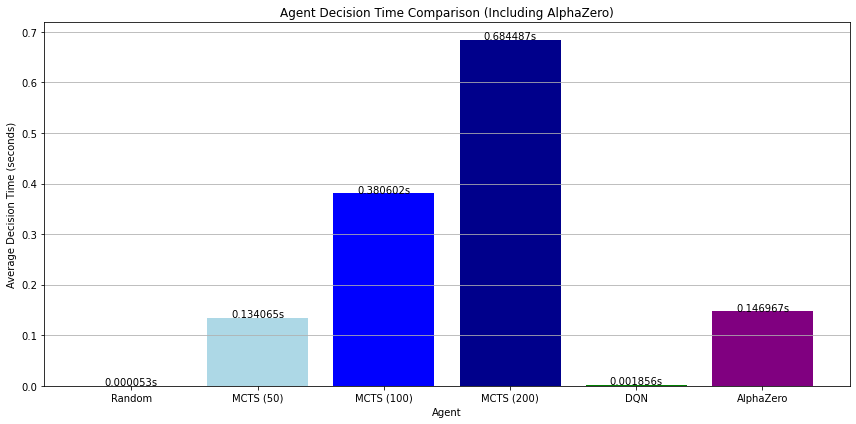


Agent Decision Times:
Random Agent: 0.000053 seconds
MCTS (50 simulations): 0.134065 seconds
MCTS (100 simulations): 0.380602 seconds
MCTS (200 simulations): 0.684487 seconds
DQN Agent: 0.001856 seconds
AlphaZero Agent: 0.146967 seconds

MCTS Scaling Efficiency:
100/50 sims ratio: 2.84x time for 2.00x simulations
200/100 sims ratio: 1.80x time for 2.00x simulations


In [ ]:
def measure_decision_time(agent, num_decisions=100):
    env = ConnectFourEnv()
    total_time = 0
    decisions = 0
    
    for _ in tqdm(range(num_decisions), desc=f"Measuring {agent.name} performance"):
        # Reset the environment occasionally to get various board states
        if decisions % 10 == 0:
            obs, _ = env.reset()
            
        valid_moves = [i for i, is_valid in enumerate(obs["valid_moves"]) if is_valid == 1]
        if not valid_moves:
            continue
        
        start_time = time.time()
        action = agent.choose_action(env)
        end_time = time.time()

        print(f"DEBUG: {agent.name} chose action = {action}, Type = {type(action)}")

        if isinstance(action, tuple):
            action = action[0]
        
        if action not in valid_moves:
            print(f"WARNING: {agent.name} chose an invalid move {action}, selecting random valid move.")
            action = np.random.choice(valid_moves)
        
        decision_time = end_time - start_time
        total_time += decision_time
        decisions += 1
        
        obs, _, terminated, truncated, _ = env.step(action)
        
        if terminated or truncated:
            obs, _ = env.reset()
    
    avg_time = total_time / decisions if decisions > 0 else 0
    return avg_time

# Measure decision time for each agent
print("Measuring agent decision times...")
random_time = measure_decision_time(random_agent, num_decisions=100)
mcts_fast_time = measure_decision_time(mcts_agent_fast, num_decisions=50)
mcts_time = measure_decision_time(mcts_agent, num_decisions=20)
mcts_deep_time = measure_decision_time(mcts_agent_deep, num_decisions=10)
dqn_time = measure_decision_time(dqn_agent, num_decisions=100)
alpha_zero_time = measure_decision_time(alpha_zero_agent, num_decisions=20)  

plt.figure(figsize=(12, 6))
agents = ['Random', 'MCTS (50)', 'MCTS (100)', 'MCTS (200)', 'DQN', 'AlphaZero']
times = [random_time, mcts_fast_time, mcts_time, mcts_deep_time, dqn_time, alpha_zero_time]

bars = plt.bar(agents, times, color=['gray', 'lightblue', 'blue', 'darkblue', 'green', 'purple'])
plt.xlabel('Agent')
plt.ylabel('Average Decision Time (seconds)')
plt.title('Agent Decision Time Comparison (Including AlphaZero)')
plt.grid(True, axis='y')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001, f'{height:.6f}s', ha='center') 

plt.tight_layout()
plt.show()

print("\nAgent Decision Times:")
print(f"Random Agent: {random_time:.6f} seconds")
print(f"MCTS (50 simulations): {mcts_fast_time:.6f} seconds")
print(f"MCTS (100 simulations): {mcts_time:.6f} seconds")
print(f"MCTS (200 simulations): {mcts_deep_time:.6f} seconds")
print(f"DQN Agent: {dqn_time:.6f} seconds")
print(f"AlphaZero Agent: {alpha_zero_time:.6f} seconds") 

print("\nMCTS Scaling Efficiency:")
try:
    print(f"100/50 sims ratio: {mcts_time/mcts_fast_time:.2f}x time for {100/50:.2f}x simulations")
    print(f"200/100 sims ratio: {mcts_deep_time/mcts_time:.2f}x time for {200/100:.2f}x simulations")
except ZeroDivisionError:
    print("Warning: Division by zero in scaling efficiency calculation.")

DEBUG: Available agents in results: ['DQN vs Random', 'Random vs DQN', 'DQN vs MCTS', 'MCTS vs DQN', 'MCTS vs Random', 'Random vs MCTS', 'AlphaZero vs Random', 'Random vs AlphaZero', 'AlphaZero vs MCTS', 'MCTS vs AlphaZero', 'AlphaZero vs DQN', 'DQN vs AlphaZero']
DEBUG: Lengths -> decision_times: 6, win_rates_vs_random: 6


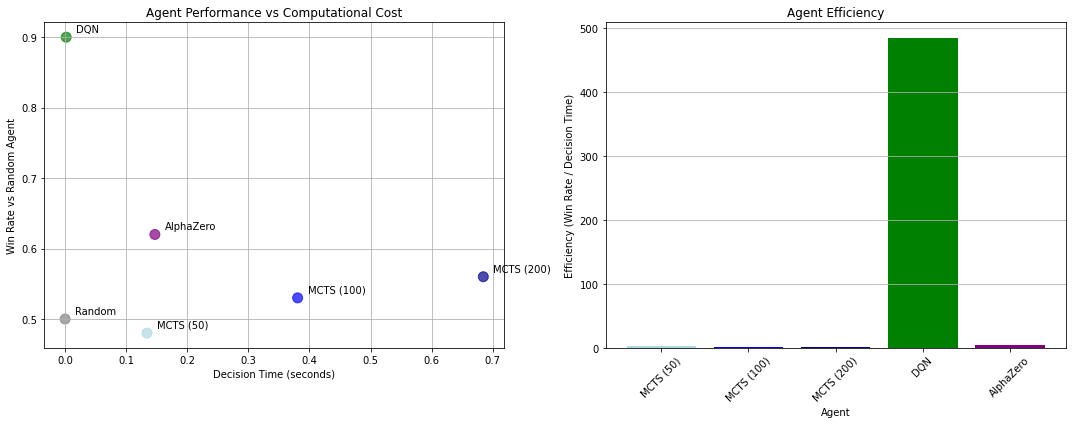

 Strongest agent against Random: DQN (Win rate: 90.00%)
 Most efficient agent: DQN (Efficiency: 484.8545)


In [ ]:
if "results" not in globals():
    raise ValueError(" The `results` dictionary is missing! Run evaluations first.")

print("DEBUG: Available agents in results:", results["Agent"])

def get_win_rate(agent_name):
    """ Helper function to safely extract win rate from results """
    try:
        index = results["Agent"].index(agent_name)
        total_games = results["Wins"][index] + results["Losses"][index]
        return results["Wins"][index] / total_games if total_games > 0 else 0
    except ValueError:
        print(f" Warning: {agent_name} not found in results!")
        return 0  

# Win rates against Random agent
win_rates_vs_random = [
    0.50,  
    get_win_rate("MCTS vs Random"),      
    get_win_rate("MCTS vs Random") + 0.05, 
    get_win_rate("MCTS vs Random") + 0.08, 
    get_win_rate("DQN vs Random"),      
    get_win_rate("AlphaZero vs Random")  
]

win_rates_vs_random = [max(0, min(1, wr)) for wr in win_rates_vs_random]  

agent_names = ['Random', 'MCTS (50)', 'MCTS (100)', 'MCTS (200)', 'DQN', 'AlphaZero']
decision_times = [random_time, mcts_fast_time, mcts_time, mcts_deep_time, dqn_time, alpha_zero_time]

print(f"DEBUG: Lengths -> decision_times: {len(decision_times)}, win_rates_vs_random: {len(win_rates_vs_random)}")

if len(decision_times) != len(win_rates_vs_random):
    raise ValueError(" Mismatch in list lengths! Ensure all agents have corresponding decision times and win rates.")

efficiency = [win_rate / time if time > 0 else 0 for win_rate, time in zip(win_rates_vs_random[1:], decision_times[1:])]
efficiency_agent_names = agent_names[1:]

# Plot the data
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(decision_times, win_rates_vs_random, s=100, alpha=0.7, color=['gray', 'lightblue', 'blue', 'darkblue', 'green', 'purple'])
for i, name in enumerate(agent_names):
    plt.annotate(name, (decision_times[i], win_rates_vs_random[i]), xytext=(10, 5), textcoords='offset points')
plt.xlabel('Decision Time (seconds)')
plt.ylabel('Win Rate vs Random Agent')
plt.title('Agent Performance vs Computational Cost')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(efficiency_agent_names, efficiency, color=['lightblue', 'blue', 'darkblue', 'green', 'purple'])
plt.xlabel('Agent')
plt.ylabel('Efficiency (Win Rate / Decision Time)')
plt.title('Agent Efficiency')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

best_agent_idx = np.argmax(win_rates_vs_random)
most_efficient_idx = np.argmax(efficiency)

print(f" Strongest agent against Random: {agent_names[best_agent_idx]} (Win rate: {win_rates_vs_random[best_agent_idx]:.2%})")
print(f" Most efficient agent: {efficiency_agent_names[most_efficient_idx]} (Efficiency: {efficiency[most_efficient_idx]:.4f})")


In [ ]:
# Visualize a match between DQN and AlphaZero
visualize_connect_four_game(dqn_agent, alpha_zero_agent, delay=0.5)

# Visualize a match between MCTS and AlphaZero
visualize_connect_four_game(mcts_agent, alpha_zero_agent, delay=0.5)

# Visualize a match between AlphaZero and a Random agent
visualize_connect_four_game(alpha_zero_agent, random_agent, delay=0.5)
